In [19]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import wcs, Sip
from astropy.io import fits
import os

Let's open the example world coordinate system which includes SIP distortion coefficients from the `astropy` tests.

In [20]:
hdu = fits.open(os.path.join(os.path.dirname(wcs.__file__), 'tests/data/sip.fits'))
w0 = wcs.WCS(hdu[0].header)
hdu.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fbb27a9f7b8>]>

The WCS contains the regular keywords, as well as a `SIP` object, which has two matrices, one of the distortion correction of each coordinat.

In [21]:
print(w0)
print(np.matrix(w0.sip.a))
print(np.matrix(w0.sip.b))

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 202.482322805  47.17511893  
CRPIX : 128.0  128.0  
PC1_1 PC1_2  : 0.000249756880272  0.000230177809744  
PC2_1 PC2_2  : 0.000230428519265  -0.000249965770577  
CDELT : 1.0  1.0  
NAXIS : 0  0
[[ 0.0000e+00  0.0000e+00  2.9656e-06  3.7746e-09]
 [ 0.0000e+00  2.1886e-05 -1.6847e-07  0.0000e+00]
 [-2.3863e-05 -8.5610e-09  0.0000e+00  0.0000e+00]
 [-1.4172e-07  0.0000e+00  0.0000e+00  0.0000e+00]]
[[ 0.0000e+00  0.0000e+00  2.3100e-05 -1.6168e-07]
 [ 0.0000e+00 -2.4386e-05 -5.7813e-09  0.0000e+00]
 [ 2.1197e-06 -1.6583e-07  0.0000e+00  0.0000e+00]
 [-2.0249e-08  0.0000e+00  0.0000e+00  0.0000e+00]]


Assuming a $256x256$ pixel image, let's generate random positions.

In [24]:
npoints = 500
x, y = 256.0*np.random.random(npoints), 256.0*np.random.random(npoints)

Use the WCS and SIP coefficients to generate celestial positions.

In [25]:
ra, dec = w0.all_pix2world(np.stack((x, y), axis=1), 1).T

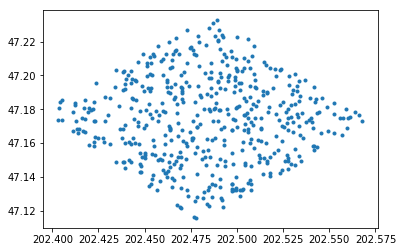

In [26]:
plt.plot(ra, dec, ".")

In [27]:
def solve_linear_equation(a, b):
    q, r = np.linalg.qr(a)
    y = np.dot(q.T, b)
    x = np.linalg.solve(r, y)
    return x

In [39]:
ra0, dec0 = 202.4, 47.2
x0, y0 = 128, 128
dx, dy = x-x0, y-y0

order = 3
ixs, iys = np.meshgrid(np.arange(order+1), np.arange(order+1))
c=ixs+iys<=order
ix, iy = ixs[c], iys[c]

a = np.array([dx**ix[i]*dy**iy[i] for i in range(len(iy))]).T

for k in range(5):
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    w.wcs.cd = [[1.0, 0.0], [0.0, 1.0]]
    w.wcs.crval = [ra0, dec0]
    w.wcs.crpix = [0.0, 0.0]

    p = w.wcs_world2pix(ra, dec, 1)
    rx, ry = p[0], p[1]
    
    ax = solve_linear_equation(a, rx)
    ay = solve_linear_equation(a, ry)

    print(ra0, dec0, ax[0], ay[0])
    
    ra0, dec0 = w.wcs_pix2world(([[ax[0], ay[0]]]), 1)[0]

202.4 47.2 0.05595975172581192 -0.024851586320874506
202.4823228050438 47.17511892998695 -2.9771387867098375e-11 1.3050169506989659e-11
202.48232280499997 47.17511893 1.9429728103572433e-14 2.2074868243857405e-15
202.482322805 47.17511893 4.3152455970840006e-16 1.7709099197795207e-15
202.482322805 47.17511893 4.3152455970840006e-16 1.7709099197795207e-15


In [40]:
print(ra0, dec0)
print(w0.wcs.crval)

202.482322805 47.17511893
[202.4823228   47.17511893]


In [41]:
cd = np.array([[ax[1], ax[order+1]], [ay[1], ay[order+1]]])
cdinv = np.linalg.inv(cd)

In [43]:
print(cd)
print(w0.wcs.pc)

[[ 0.00024976  0.00023018]
 [ 0.00023043 -0.00024997]]
[[ 0.00024976  0.00023018]
 [ 0.00023043 -0.00024997]]


In [44]:
axm = np.zeros_like(ixs).astype("float32")
aym = np.zeros_like(ixs).astype("float32")
for i in range(len(ix)):
    if ix[i]+iy[i]>=2:
        p = np.matmul(cdinv, np.array([ax[i], ay[i]]))
        axm[iy[i], ix[i]] = p[0]
        aym[iy[i], ix[i]] = p[1]   

In [45]:
print(np.matrix(axm.T))
print(np.matrix(w0.sip.a))

[[ 0.0000e+00  0.0000e+00  2.9656e-06  3.7746e-09]
 [ 0.0000e+00  2.1886e-05 -1.6847e-07  0.0000e+00]
 [-2.3863e-05 -8.5610e-09  0.0000e+00  0.0000e+00]
 [-1.4172e-07  0.0000e+00  0.0000e+00  0.0000e+00]]
[[ 0.0000e+00  0.0000e+00  2.9656e-06  3.7746e-09]
 [ 0.0000e+00  2.1886e-05 -1.6847e-07  0.0000e+00]
 [-2.3863e-05 -8.5610e-09  0.0000e+00  0.0000e+00]
 [-1.4172e-07  0.0000e+00  0.0000e+00  0.0000e+00]]


In [37]:
print(np.matrix(aym.T))
print(np.matrix(w0.sip.b))

[[ 0.0000e+00  0.0000e+00  2.3100e-05 -1.6168e-07]
 [ 0.0000e+00 -2.4386e-05 -5.7813e-09  0.0000e+00]
 [ 2.1197e-06 -1.6583e-07  0.0000e+00  0.0000e+00]
 [-2.0249e-08  0.0000e+00  0.0000e+00  0.0000e+00]]
[[ 0.0000e+00  0.0000e+00  2.3100e-05 -1.6168e-07]
 [ 0.0000e+00 -2.4386e-05 -5.7813e-09  0.0000e+00]
 [ 2.1197e-06 -1.6583e-07  0.0000e+00  0.0000e+00]
 [-2.0249e-08  0.0000e+00  0.0000e+00  0.0000e+00]]
